In [2]:
# All imports
import os
import xml.etree.ElementTree as ET

from skimage import io, filters, exposure
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import numpy as np, pandas as pd
import glob
import json


In [3]:
# 2. Convert images from all 4 classes to edge histograms
    # (Using the processed image data from assignment 1, images are cropped and resized)
    # (Using same code from assignment 1 in PCA section which converts images to histograms)

data_path = "./Processed_Data"
classes = ['n02085782-Japanese_spaniel', 
           'n02093428-American_Staffordshire_terrier', 
           'n02105056-groenendael', 
           'n02113186-Cardigan']
image_paths = []

# get all the paths
for classes_dir in classes:
    class_path = os.path.join(data_path, classes_dir)
    image_paths += [os.path.join(class_path, img) for img in os.listdir(class_path)]

histograms = []
gray_imgs = []

# convert images to grayscale
for img_path in image_paths:
    image = Image.open(img_path)
    image_array = np.array(image)
    gray = rgb2gray(image_array)
    gray_imgs.append(gray)

# same function from above copied down
def angle(dx, dy):
    return np.mod(np.arctan2(dy,dx), np.pi)
    
angles = []
for gray in gray_imgs:
    angle_sobel = angle(filters.sobel_h(gray),
                        filters.sobel_v(gray))
    angles.append(angle_sobel)

# make a histogram with 36 bins
for angle_sobel in angles:
    hist, bin_centers = exposure.histogram(angle_sobel, nbins=36)
    histograms.append(hist)


In [4]:
# 3. Split dataset into training and test set
    # For each class, perform split of 80/20
    # https://scikit-learn.org/1.5/modules/generated/sklearn.model_selection.train_test_split.html

# separate histograms by class
class_hist = {class_name: [] for class_name in classes}
for i, img_path in enumerate(image_paths):
    for class_name in classes:
        if class_name in img_path:
            class_hist[class_name].append(histograms[i])
            break

# 80/20 split on histograms for each class
train_hist = []
test_hist = []
for class_name, hist in class_hist.items():
    train, test = train_test_split(hist, test_size=0.2, random_state=42)
    train_hist.extend(train)
    test_hist.extend(test)


In [5]:
# 4. Standardization on training data
    # https://scikit-learn.org/stable/modules/preprocessing.html
scaler = preprocessing.StandardScaler()
train_hist_scaler = scaler.fit_transform(train_hist)


# 5. Standardization on test data using means and variances from training data
test_hist_scalar = scaler.transform(test_hist)


Gaussian NB - Mean Validation Accuracy: 0.33153153153153153
Gaussian NB - Accuracy: 0.36879432624113473, F1 Score: 0.3233086263920469


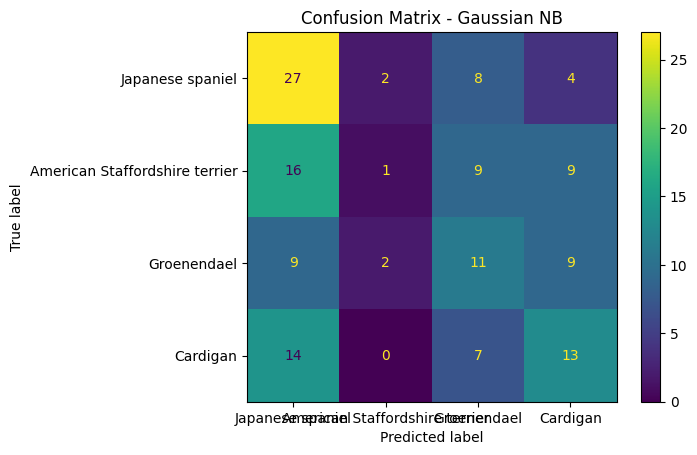

Decision Tree - Mean Validation Accuracy: 0.2684684684684685
Decision Tree - Accuracy: 0.2695035460992908, F1 Score: 0.27058329225882416


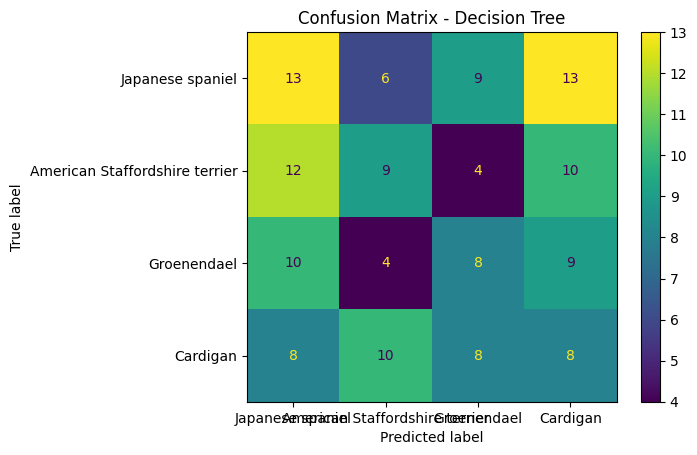

AdaBoost - Mean Validation Accuracy: 0.31171171171171175
AdaBoost - Accuracy: 0.3900709219858156, F1 Score: 0.3760560837499115


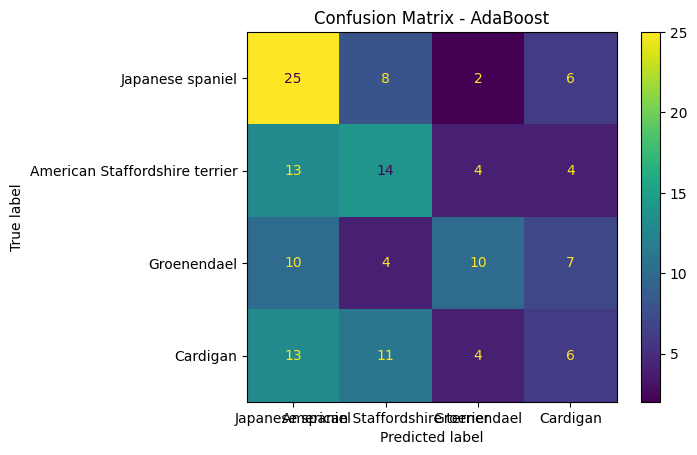

In [10]:
# 6. Stratified 5-fold cross-validation on the 4-class classification problem
    # using the 3 classification methods (Naive Bayes, Decision Tree, Adaboost).
    # Plot the 3 confusion matrices for using 3 approaches (label classes) on test set.
    
    # https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.StratifiedKFold.html
    # https://www.geeksforgeeks.org/stratified-k-fold-cross-validation/
    # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict
    # https://scikit-learn.org/stable/modules/cross_validation.html
    # https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.f1_score.html
    # https://scikit-learn.org/dev/modules/generated/sklearn.metrics.accuracy_score.html
    
    # https://scikit-learn.org/dev/modules/generated/sklearn.naive_bayes.GaussianNB.html
    # https://scikit-learn.org/dev/modules/generated/sklearn.tree.DecisionTreeClassifier.html
    # https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    
    # https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.confusion_matrix.html
    # https://scikit-learn.org/dev/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html

# Initialize classifiers
classifiers = {
    "Gaussian NB": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=10), 
    "AdaBoost": AdaBoostClassifier(algorithm='SAMME')  
    # default algorithm gives a warning of deprecation, so using SAMME algo
}

# Labels for when plotting
classes_label = ['Japanese spaniel', 
           'American Staffordshire terrier', 
           'Groenendael', 
           'Cardigan']

# class labels for training and test sets
train_labels = []
test_labels = []

for class_name, hist in class_hist.items():
    train_size = int(0.8 * len(hist))
    train_labels.extend([class_name] * train_size)  
    test_labels.extend([class_name] * (len(hist) - train_size)) 

# Setting up stratified 5-fold cross-validation
skf = StratifiedKFold(n_splits=5)


# Function for cross-validation and plots the confusion matrix
def evaluate_classifier(clf, clf_name, X_train, y_train, X_test, y_test):
    # skf predictions and mean validation accuracy
    y_pred = cross_val_predict(clf, X_train, y_train, cv=skf)
    scores = cross_val_score(clf, X_train, y_train, cv=skf, scoring='accuracy')
    print(f"{clf_name} - Mean Validation Accuracy: {scores.mean()}")

    # Train on training set and predict on test
    clf.fit(X_train, y_train)
    y_test_pred = clf.predict(X_test)
    
    # Accuracy and F1-scores
    accuracy = accuracy_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred, average="weighted")
    print(f"{clf_name} - Accuracy: {accuracy}, F1 Score: {f1}")

    # confusion matrix display
    cm = confusion_matrix(y_test, y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes_label)
    disp.plot()
    plt.title(f"Confusion Matrix - {clf_name}")
    plt.show()


# Call function for each classifier
for clf_name, clf in classifiers.items():
    evaluate_classifier(clf, clf_name, train_hist_scaler, train_labels, test_hist_scalar, test_labels)



# By visually comparing the three confusion matrices, which do you think is the best method?
    # Visual comparison of the three matrices shows that the decision tree has the most
    # counts of correct predictions for each class, which can be seen in the diagonal cells.
# Based on mean validation accuracies for the three methods, which is the best method?
    # The mean validation accuracy for Gaussian NB is the highest, so that is the
    # best method.
# Compute accuracies for the three methods on the test set. Which is the best method?
    # The accuracy for Gaussian NB is the highest, so it is the best method.
# Compute f-measure for the three methods. Which is the best method?
    # The f-measure for Gaussian NB is the highest, so it is the best method.



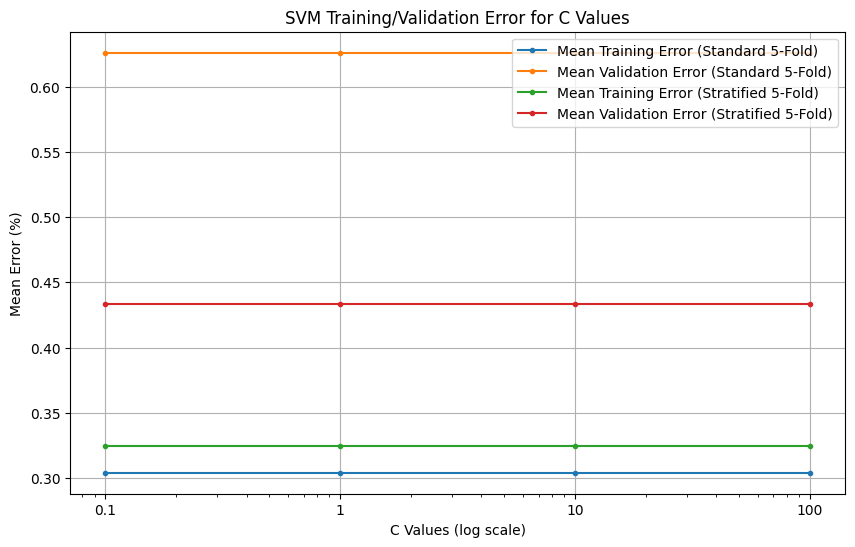

In [7]:
# 7. Use images from 2 classes. Perform standard 5-fold cross-validation
    # and a stratified 5-fold cross-validation on the training set for
    # Support Vector Classifiers using LinearSVC such that parameter
    # C = 0.1, 1, 10, 100 and other parameters set as default

# Use only two classes
selected_classes = ['n02085782-Japanese_spaniel', 'n02093428-American_Staffordshire_terrier']
selected_train_hist = [hist for i, hist in enumerate(train_hist) if any(cls in image_paths[i] for cls in selected_classes)]
# Create a list of labels for the selected classes
selected_train_labels = []

for i, img_path in enumerate(image_paths):
    if any(cls in img_path for cls in selected_classes):
        selected_train_labels.append(next(cls for cls in selected_classes if cls in img_path))

# Convert lists to numpy arrays for easier manipulation
selected_train_hist = np.array(selected_train_hist)
selected_train_labels = np.array(selected_train_labels)

C_values = [0.1, 1, 10, 100]
mean_train_errors_standard = []
mean_val_errors_standard = []
mean_train_errors_stratified = []
mean_val_errors_stratified = []

# Create K-Fold cross validation
kf = KFold(n_splits=5)

# Iterate over C values for standard K-Fold
for C in C_values:
    train_errors = []
    val_errors = []
    
    for train_index, val_index in kf.split(selected_train_hist):
        X_train, X_val = selected_train_hist[train_index], selected_train_hist[val_index]
        y_train, y_val = selected_train_labels[train_index], selected_train_labels[val_index]

        # Fit the model
        svm_model = LinearSVC(C=C)
        svm_model.fit(X_train, y_train)

        # Calculate errors
        train_error = 1 - svm_model.score(X_train, y_train)
        val_error = 1 - svm_model.score(X_val, y_val)

        train_errors.append(train_error)
        val_errors.append(val_error)

    mean_train_errors_standard.append(np.mean(train_errors))
    mean_val_errors_standard.append(np.mean(val_errors))

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over C values for stratified K-Fold
for C in C_values:
    train_errors = []
    val_errors = []
    
    for train_index, val_index in skf.split(selected_train_hist, selected_train_labels):
        X_train, X_val = selected_train_hist[train_index], selected_train_hist[val_index]
        y_train, y_val = selected_train_labels[train_index], selected_train_labels[val_index]

        # Fit the model
        svm_model = LinearSVC(C=C, random_state=42)
        svm_model.fit(X_train, y_train)

        # Calculate errors
        train_error = 1 - svm_model.score(X_train, y_train)
        val_error = 1 - svm_model.score(X_val, y_val)

        train_errors.append(train_error)
        val_errors.append(val_error)

    mean_train_errors_stratified.append(np.mean(train_errors))
    mean_val_errors_stratified.append(np.mean(val_errors))

# Plotting the errors
plt.figure(figsize=(10, 6))

# Standard K-Fold error curves
plt.plot(C_values, mean_train_errors_standard, marker='.', label='Mean Training Error (Standard 5-Fold)')
plt.plot(C_values, mean_val_errors_standard, marker='.', label='Mean Validation Error (Standard 5-Fold)')

# Stratified K-Fold error curves
plt.plot(C_values, mean_train_errors_stratified, marker='.', label='Mean Training Error (Stratified 5-Fold)')
plt.plot(C_values, mean_val_errors_stratified, marker='.', label='Mean Validation Error (Stratified 5-Fold)')

plt.xscale('log')
plt.xticks(C_values, labels=[str(C) for C in C_values])
plt.xlabel('C Values (log scale)')
plt.ylabel('Mean Error (%)')
plt.title('SVM Training/Validation Error for C Values')
plt.legend()
plt.grid()
plt.show()

# Which C has/have the lowest mean error for each curve? Comment about (1) the model
# complexity for SVM in relation to C, and (2) when/whether there is overfitting/underfitting.
    # My mean errors for each C value seems to be the same, so I don't necessarily have a
    # a C value that has the lowest mean error for each curve. 
